In [1]:
# Load optical PLN imaging data
import numpy as np
from skimage import io
import os

# Define path to optical PLN images
data_path = "Optical PLN Imaging.tif"

# Load the image stack directly using skimage.io
image_stack = io.imread(data_path)

# Convert to numpy array if not already
image_stack = np.array(image_stack)

print(f"Loaded image stack with shape: {image_stack.shape}")


Loaded image stack with shape: (1800, 1080, 2048)


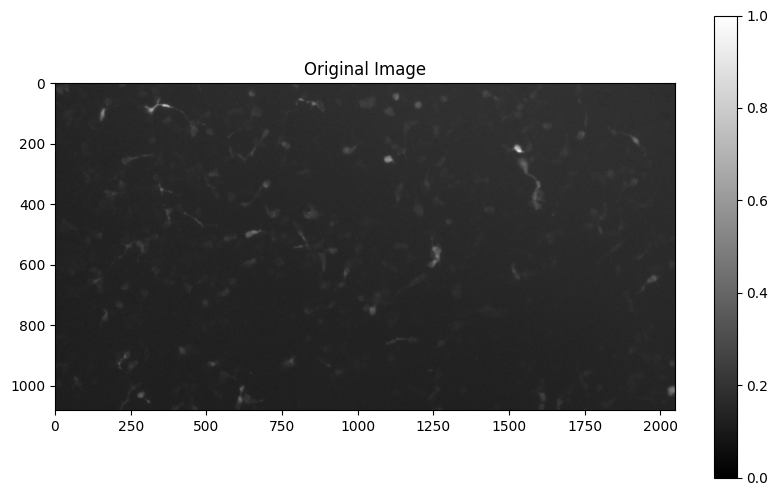

In [2]:
# Import required packages for visualization
import matplotlib.pyplot as plt

# Get first image
img = image_stack[0]

# Normalize image to 0-1 range
img = (img - img.min()) / (img.max() - img.min())

# Create figure and plot
plt.figure(figsize=(10, 6))
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.colorbar()
plt.show()


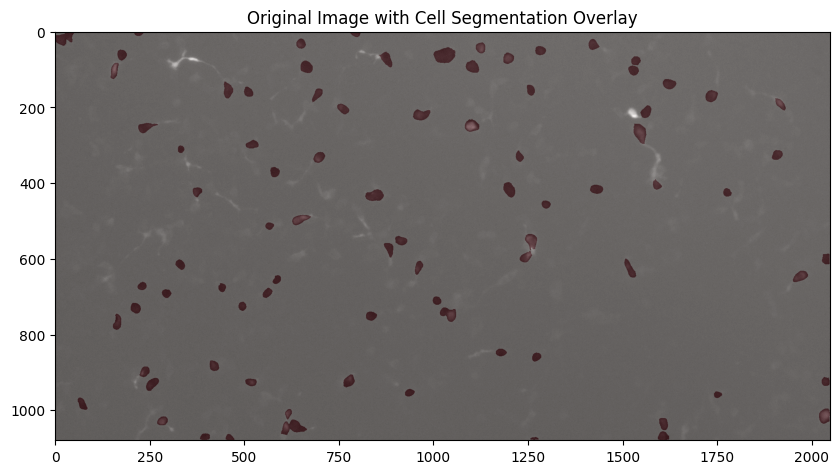

In [3]:
# Import required packages for cell segmentation
from cellpose import models
import matplotlib.pyplot as plt
import numpy as np

# Get first image
img = image_stack[0]

# Normalize image to 0-1 range
img = (img - img.min()) / (img.max() - img.min())

# Initialize the Cellpose model
# Using 'cyto' model which is trained on cytoplasm images
model = models.Cellpose(model_type='cyto', gpu=True)  # Enable GPU if available

# Process parameters
channels = [0, 0]  # grayscale images
diameter = 30  # approximate cell diameter in pixels

# Run cellpose on the image
mask, flows, styles, diams = model.eval(img,
                                      diameter=diameter, 
                                      channels=channels,
                                      flow_threshold=0.4,
                                      cellprob_threshold=0.0)

# Create figure
plt.figure(figsize=(10, 6))

# Plot original image
plt.imshow(img, cmap='gray')

# Create mask overlay
mask_overlay = np.zeros_like(img)
for cell_id in range(1, len(np.unique(mask))):
    cell_boundary = (mask == cell_id)
    mask_overlay[cell_boundary] = 1

# Overlay cell boundaries in red with partial transparency
plt.imshow(mask_overlay, cmap='Reds', alpha=0.3)
plt.title('Original Image with Cell Segmentation Overlay')
plt.show()


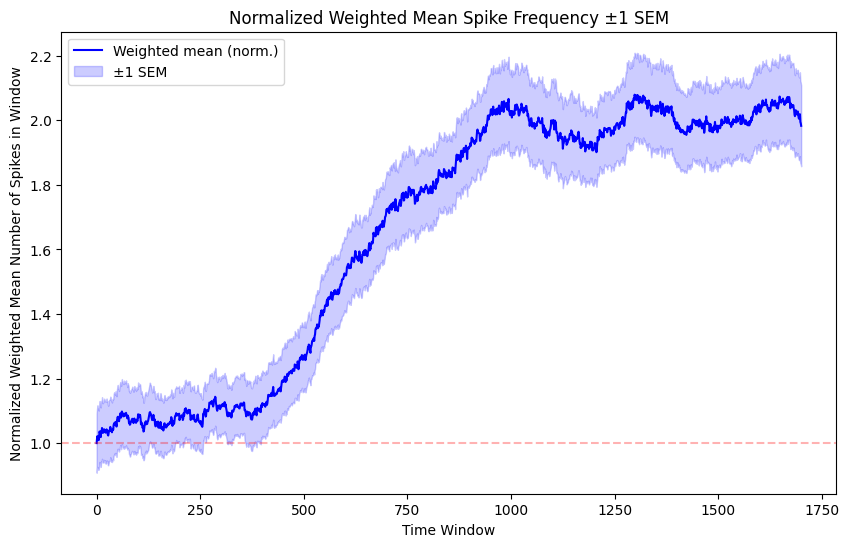

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

# Get number of unique cells (excluding background which is 0)
n_cells = len(np.unique(mask)) - 1

# Set up parameters
window_size = 100
step_size = 1  # Can be adjusted for computational efficiency

# Calculate number of windows
n_windows = len(image_stack) - window_size + 1

# Initialize arrays to store frequencies and std for each cell
cell_frequencies = np.zeros((n_cells, n_windows))
total_spikes = np.zeros(n_cells)

# First pass - calculate total spikes per cell for weights
for cell_id in range(1, n_cells + 1):
    # Get the trace for current cell
    cell_trace = image_stack[:, mask == cell_id].mean(axis=1)
    
    # Apply smoothing to reduce noise
    cell_trace = gaussian_filter1d(cell_trace, sigma=0.25)

    # Find peaks in the trace
    peaks, _ = find_peaks(cell_trace, prominence=25)
    
    # Store total spikes for this cell
    total_spikes[cell_id-1] = len(peaks)

    # Calculate spike frequencies for this cell
    for i in range(n_windows):
        window_start = i
        window_end = i + window_size
        # Count peaks that fall within this window
        peaks_in_window = np.sum((peaks >= window_start) & (peaks < window_end))
        cell_frequencies[cell_id-1, i] = peaks_in_window

# Calculate weights
weights = total_spikes / np.sum(total_spikes)

# Calculate weighted average per window
weighted_avg_frequencies = np.average(cell_frequencies, axis=0, weights=weights)

# --- begin modified error‐bar computation ---

# 1) Unbiased weighted variance (Bessel’s correction):
den = 1.0 - np.sum(weights**2)  # since sum(weights) == 1
var_unbiased = np.sum(weights[:, None] * (cell_frequencies - weighted_avg_frequencies)**2, axis=0) / den
sigma_unbiased = np.sqrt(var_unbiased)

# 2) Effective sample size:
n_eff = 1.0 / np.sum(weights**2)

# 3) Standard error of the weighted mean:
stderr = sigma_unbiased / np.sqrt(n_eff)

# 4) Normalize to starting frequency
starting_frequency = weighted_avg_frequencies[0]
if starting_frequency == 0:
    raise ValueError("No spikes in initial window; cannot normalize.")

norm_mean = weighted_avg_frequencies / starting_frequency
norm_stderr = stderr / starting_frequency

# --- end modified error‐bar computation ---

# Create figure
plt.figure(figsize=(10, 6))

# Plot the main line
plt.plot(norm_mean, 'b-', label='Weighted mean (norm.)')

# Add shaded SEM region (±1 SEM)
plt.fill_between(
    np.arange(len(norm_mean)),
    norm_mean - norm_stderr,
    norm_mean + norm_stderr,
    color='b', alpha=0.2,
    label='±1 SEM'
)

plt.title('Normalized Weighted Mean Spike Frequency ±1 SEM')
plt.xlabel('Time Window')
plt.ylabel('Normalized Weighted Mean Number of Spikes in Window')
plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)  # reference line at 1
plt.legend()
plt.show()

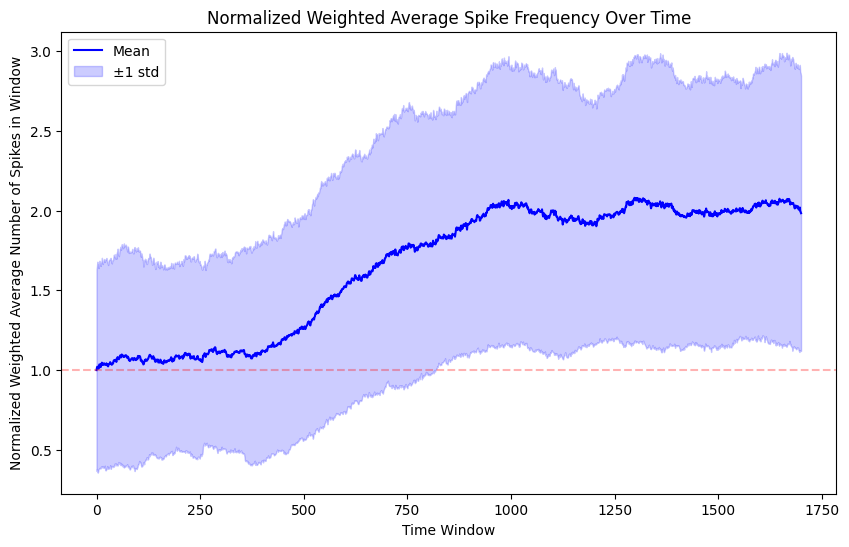

In [6]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

# Get number of unique cells (excluding background which is 0)
n_cells = len(np.unique(mask)) - 1

# Set up parameters
window_size = 100
step_size = 1  # Can be adjusted for computational efficiency

# Calculate number of windows
n_windows = len(image_stack) - window_size + 1

# Initialize arrays to store frequencies and std for each cell
cell_frequencies = np.zeros((n_cells, n_windows))
total_spikes = np.zeros(n_cells)

# First pass - calculate total spikes per cell for weights
for cell_id in range(1, n_cells + 1):
    # Get the trace for current cell
    cell_trace = image_stack[:, mask == cell_id].mean(axis=1)
    
    # Apply smoothing to reduce noise
    cell_trace = gaussian_filter1d(cell_trace, sigma=0.25)

    # Find peaks in the trace
    peaks, _ = find_peaks(cell_trace, prominence=25)
    
    # Store total spikes for this cell
    total_spikes[cell_id-1] = len(peaks)

    # Calculate spike frequencies for this cell
    for i in range(n_windows):
        window_start = i
        window_end = i + window_size
        # Count peaks that fall within this window
        peaks_in_window = np.sum((peaks >= window_start) & (peaks < window_end))
        cell_frequencies[cell_id-1, i] = peaks_in_window

# Calculate weights
weights = total_spikes / np.sum(total_spikes)

# Calculate weighted average and standard deviation
weighted_avg_frequencies = np.average(cell_frequencies, axis=0, weights=weights)
weighted_std = np.sqrt(np.average((cell_frequencies - weighted_avg_frequencies)**2, axis=0, weights=weights))

# Normalize frequencies and std to the starting frequency
starting_frequency = weighted_avg_frequencies[0]
normalized_frequencies = weighted_avg_frequencies / starting_frequency
normalized_std = weighted_std / starting_frequency

# Create figure
plt.figure(figsize=(10, 6))

# Plot the main line
plt.plot(normalized_frequencies, 'b-', label='Mean')

# Add shaded error region (±1 standard deviation)
plt.fill_between(range(len(normalized_frequencies)),
                 normalized_frequencies - normalized_std,
                 normalized_frequencies + normalized_std,
                 color='b', alpha=0.2, label='±1 std')

plt.title('Normalized Weighted Average Spike Frequency Over Time')
plt.xlabel('Time Window')
plt.ylabel('Normalized Weighted Average Number of Spikes in Window')
plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)  # Add reference line at 1
plt.legend()
plt.show()
